# Extracting Farm Boundaries using Segment Geospatial

## Introduction

We use the [samgeo](https://samgeo.gishub.org/) package to automatically segment a GeoTIFF image and extract the farm boundaries as a vector layer. This is an example of zero-shot learning where we are able to extract the boundaries without providing any training samples or prompts.

## Overview of the Task

The Segment Anything model requires 3-band color imagery as the input. We take colorized image of NDVI derived from a Landsat image and use it to extract the boundaries of central-pivot irrigation farms present in the image.

**Input Layers**:
* `central_pivot_ndvi.tif`: A GeoTIFF image of NDVI computed from a Landsat-8 composite. The image has been exported from Google Earth Engine. See [reference script](https://code.earthengine.google.co.in/7a1225b1f6eab201e4794f85dcc415a3).

**Output Layers**:
* `segment.shp`: A shapefile containing polygons of centroal-pivot irrigated farms.

**Data Credit**
* Landsat-8 image courtesy of the U.S. Geological Survey



In [2]:
# Installation of segment-geospatial can take a few minutes. Please be patient
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install segment-geospatial rioxarray

In [10]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import rioxarray as rxr
from samgeo import SamGeo
import zipfile

In [4]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [5]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

image = 'central_pivot_ndvi.tif'

download(data_url + image)

Downloaded data/central_pivot_ndvi.tif


## Load the Image

In [8]:
image_path = os.path.join(data_folder, image)
image = rxr.open_rasterio(image_path)

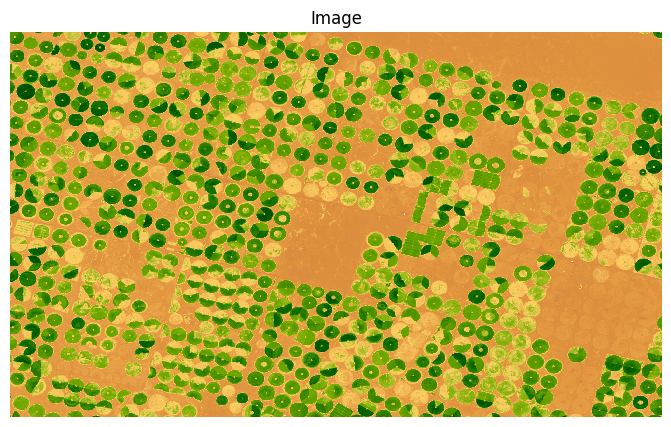

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
image.plot.imshow(ax=ax)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('Image')
plt.show()

## Segment the Image

In [ ]:
sam = SamGeo(
    model_type='vit_h',
    #checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=None,
)

In [19]:
mask = 'segment.tif'
mask_path = os.path.join(output_folder, mask)
sam.generate(image_path, mask_path, unique=True)

## Polygonize the Results

Save the segmentation results as a shapefile.

In [22]:
shapefile = 'segment.shp'
shapefile_path = os.path.join(output_folder, shapefile)
sam.tiff_to_shp(mask_path, shapefile_path, simplify_tolerance=None)

Visualize the results.

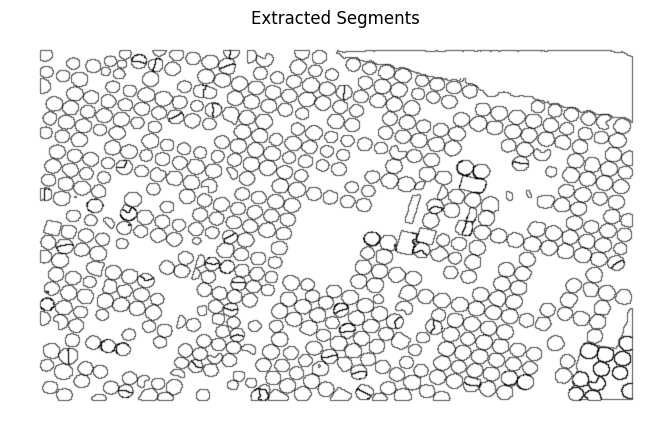

In [32]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
segments_gdf = gpd.read_file(shapefile_path)
segments_gdf.plot(
    ax=ax,
    linewidth=1,
    facecolor='none',
    alpha=0.5
)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('Extracted Segments')
plt.show()

The shapefile contains farm boundaries along with background polygon covering the entire region. As we had specified `unique=True` when generating the mask polygons, each polygon contains a unique id which is proporation to its area. The larger *values* indicate large polygons.

In [24]:
gdf = gpd.read_file(shapefile_path)
gdf.sort_values('value', ascending=False)

,value,geometry
127,630.0,"POLYGON ((38.28386 30.27098, 38.28494 30.27098..."
981,629.0,"POLYGON ((38.43289 30.05619, 38.43316 30.05619..."
778,629.0,"POLYGON ((38.44044 30.09042, 38.44071 30.09042..."
930,629.0,"POLYGON ((38.42723 30.06266, 38.4275 30.06266,..."
771,629.0,"POLYGON ((38.43774 30.09123, 38.43801 30.09123..."
...,...,...
592,5.0,"POLYGON ((38.16582 30.13381, 38.16636 30.13381..."
228,4.0,"POLYGON ((38.151 30.20307, 38.15423 30.20307, ..."
485,3.0,"POLYGON ((38.19682 30.15591, 38.19816 30.15591..."
333,2.0,"POLYGON ((38.38816 30.18393, 38.38977 30.18393..."


We select a threshold and remove larger polygons.

In [27]:
threshold = 629
cleaned_gdf = gdf[gdf['value'] < threshold]

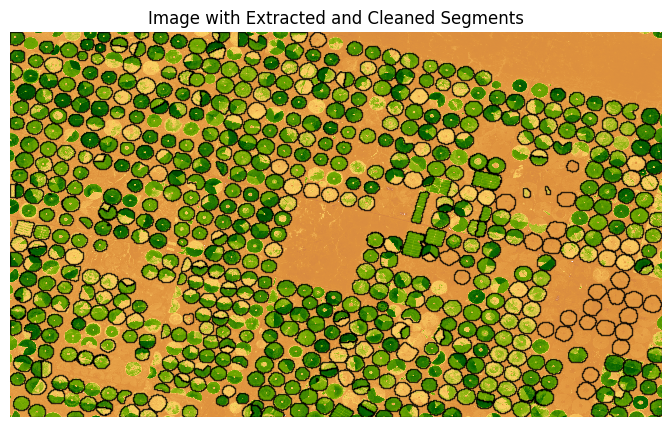

In [33]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
image.plot.imshow(ax=ax)
cleaned_gdf.plot(
    ax=ax,
    linewidth=1,
    facecolor='none',
    alpha=0.8
)
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('Image with Extracted and Cleaned Segments')
plt.show()

Save the results as a zipped shapefile.

In [29]:
edited_shapefile = 'segmentation_results.shp'
edited_shapefile_path = os.path.join(output_folder, edited_shapefile)
cleaned_gdf.to_file(edited_shapefile_path)

zipfile_name = 'segmentation_results.zip'

shapefile_base = os.path.splitext(edited_shapefile_path)[0]

zipfile_path = os.path.join(output_folder, zipfile_name)
with zipfile.ZipFile(zipfile_path, 'w') as zipf:
  # Add the shapefile and its associated files
  for ext in ['.shp', '.shx', '.dbf', '.prj']:
      file_path = shapefile_base + ext
      print(file_path)
      if os.path.exists(file_path):
          zipf.write(file_path, os.path.basename(file_path))



output/segmentation_results.shp
output/segmentation_results.shx
output/segmentation_results.dbf
output/segmentation_results.prj


----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>